In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

import xgboost as xgb
import matplotlib.pyplot as plt

# Content
* Loading dataset
* Removing zero variance
* Removing duplicate columns
* Select best features using Decision Tree
* Applying xgboosting to the dataset using 'auc' metrics

In [2]:
# Loading dataset
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")


In [3]:
print(train.shape, test.shape)

(76020, 371) (75818, 370)


In [4]:
y = train['TARGET']
train = train.drop(columns=['TARGET', 'ID'])

test_id = test['ID']
test = test.drop(columns=['ID'])

In [5]:
print(train.shape, test.shape)

(76020, 369) (75818, 369)


In [6]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=0)
sel.fit(train)  # fit finds the features with zero variance

VarianceThreshold(threshold=0)

In [7]:
train.columns[~sel.get_support()]

Index(['ind_var2_0', 'ind_var2', 'ind_var27_0', 'ind_var28_0', 'ind_var28',
       'ind_var27', 'ind_var41', 'ind_var46_0', 'ind_var46', 'num_var27_0',
       'num_var28_0', 'num_var28', 'num_var27', 'num_var41', 'num_var46_0',
       'num_var46', 'saldo_var28', 'saldo_var27', 'saldo_var41', 'saldo_var46',
       'imp_amort_var18_hace3', 'imp_amort_var34_hace3',
       'imp_reemb_var13_hace3', 'imp_reemb_var33_hace3',
       'imp_trasp_var17_out_hace3', 'imp_trasp_var33_out_hace3',
       'num_var2_0_ult1', 'num_var2_ult1', 'num_reemb_var13_hace3',
       'num_reemb_var33_hace3', 'num_trasp_var17_out_hace3',
       'num_trasp_var33_out_hace3', 'saldo_var2_ult1',
       'saldo_medio_var13_medio_hace3'],
      dtype='object')

In [8]:
train = train.drop(columns=train.columns[~sel.get_support()])
test = test.drop(columns=test.columns[~sel.get_support()])

In [9]:
print(train.shape, test.shape)

(76020, 335) (75818, 335)


In [10]:
# finding duplicate columns!
t = train.T.duplicated()

# removing dup. columns from the train and test dataset
train = train.drop(columns=train.columns[t.values])
test = test.drop(columns=test.columns[t.values])

In [12]:
print(train.shape, test.shape)

(76020, 306) (75818, 306)


In [26]:
# split dataset
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.12,random_state=42)
print(X_train.shape, X_test.shape, test.shape)

(66897, 306) (9123, 306) (75818, 306)


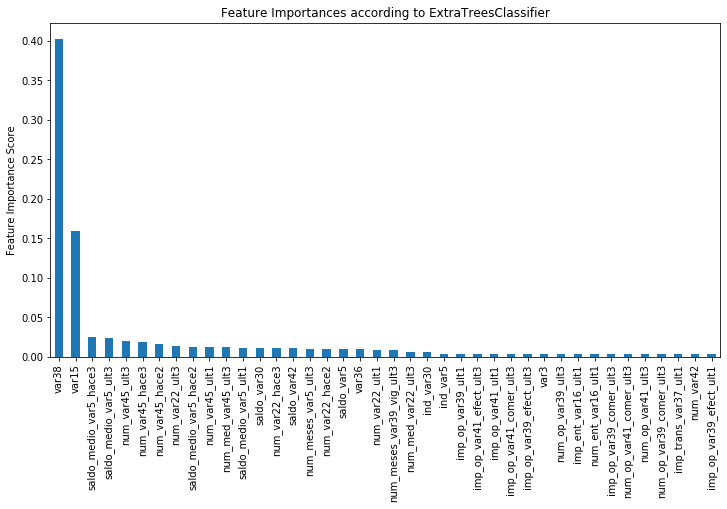

In [27]:
## # Feature selection
clf = ExtraTreesClassifier(random_state=42)
selector = clf.fit(X_train, y_train)

# plot most important 40 features
# feat_imp = pd.Series(clf.feature_importances_, index = X_train.columns.values).sort_values(ascending=False)
# feat_imp[:40].plot(kind='bar', title='Feature Importances according to ExtraTreesClassifier', figsize=(12, 8))
# plt.ylabel('Feature Importance Score')
# plt.subplots_adjust(bottom=0.3)
# plt.savefig('1.png')
# plt.show()

## SelectFromModel thresholdstring, float, optional default None
link : https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html
* The threshold value to use for feature selection. Features whose importance is greater or equal are kept while the others are discarded. If “median” (resp. “mean”), then the threshold value is the median (resp. the mean) of the feature importances. A scaling factor (e.g., “1.25*mean”) may also be used. If None and if the estimator has a parameter penalty set to l1, either explicitly or implicitly (e.g, Lasso), the threshold used is 1e-5. Otherwise, “mean” is used by default.

In [28]:
# clf.feature_importances_ 
fs = SelectFromModel(selector, prefit=True, threshold='0.75*mean')

X_train_trans = fs.transform(X_train)
X_test_trans = fs.transform(X_test)
test_trans = fs.transform(test)

print(X_train_trans.shape, X_test_trans.shape, test_trans.shape)

(66897, 57) (9123, 57) (75818, 57)


In [40]:
## # Train Model
# classifier from xgboost
m2_xgb = xgb.XGBClassifier(n_estimators=72, nthread=-1, max_depth = 6, seed=42)

m2_xgb.fit(X_train_trans, y_train, eval_metric="auc", verbose =False, eval_set=[(X_test_trans, y_test)])

# calculate the auc score
print("Roc AUC: ", roc_auc_score(y_test, m2_xgb.predict_proba(X_test_trans)[:,1], average='macro'))

Roc AUC:  0.8304499720975693


In [ ]:
## # Submission
probs = m2_xgb.predict_proba(test_trans)

submission = pd.DataFrame({"ID":test_id, "TARGET": probs[:,1]})
submission.to_csv("submission.csv", index=False)

In [29]:
# Rqndom Forest 
from sklearn.ensemble import RandomForestClassifier

In [30]:
clf = RandomForestClassifier(n_estimators=110, max_depth=4, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)

# calculate the auc score
print("Roc AUC: ", roc_auc_score(y_test, clf.predict_proba(X_test)[:,1], average='macro'))

Roc AUC:  0.7757616786397984


In [31]:
from sklearn.svm import SVC
clf = SVC(gamma='auto')
clf.fit(X_train, y_train)

In [ ]:
print(clf.score(X_test, y_test))